 <h1><center>Post Procesamiento</center></h1>

## Librerías

In [1]:
import wrf as wrf
import pathlib
import netCDF4
import pandas as pd 
import xarray as xr 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rcParams
import matplotlib.dates as mdates
import matplotlib.colors as clr

from svgpathtools import svg2paths
from svgpath2mpl import parse_path

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

## Funciones

In [3]:
def convert_longitude_to_0_360(lon):
    return (lon + 360) % 360

def mask_nan(file_name):
    nct = netCDF4.Dataset(file_name,'r',format='NETCDF4')
    mask = nct.variables['LANDMASK'][0,:,:]
    mask[mask==1] = np.nan
    mask[mask==0] = 1
    nct.close()
    return mask

def magnitud(u,v):
    suma=np.add(u[:,:]**2.,v[:,:]**2.)
    magnitud = np.sqrt(suma)
    values = magnitud
    return values

def get_nearest_index_from_xarray(ds_wrf, lat_point, lon_point):
    lat_diff = np.abs(ds_wrf.XLAT.values[0,:,:] - lat_point)
    lon_diff = np.abs(ds_wrf.XLONG.values[0,:,:] - lon_point)
    lat_index = np.unravel_index(
        np.argmin(lat_diff), ds_wrf.XLAT.values[0,:,:].shape
    )
    lon_index = np.unravel_index(
        np.argmin(lon_diff), ds_wrf.XLONG.values[0,:,:].shape
    )
    return lat_index[0], lon_index[1]

def graf_time_series_xarray(df, var, ylab):
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H \n %d %b'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    ax1.plot(df[var],'darkorange',lw=2)
    ax1.set_xlim(df.index[0], df.index[-1])
    ax1.set_ylabel(ylab,fontsize=20)
    plt.show()

def cmap_wind():
    cmap_wind = clr.LinearSegmentedColormap.from_list('Winds',
          [(0,(0,0,125/255.)),(0.05,(0,100/255.,232/255.)),(0.1,(37/255.,252/255.,0)),
           (0.15,(240/255.,253/255.,0)),(0.2,(198/255.,208/255.,0)),(0.3,(198/255.,208/255.,0)),
           (0.4,(220/255.,127/255.,0)),(0.5,(252/255.,37/255.,0)),(0.6,(239/255.,0,87/255.)),
           (0.7,(183/255.,0,176/255.)),(1,(255/255.,255/255.,255/255.))], N=256)
    bounds_wind = np.linspace(0, 90, 101, endpoint=True)
    norm_wind = clr.BoundaryNorm(boundaries=bounds_wind, ncolors=256)
    return cmap_wind, bounds_wind, norm_wind

def get_hurricane2():
    hurricane_marker =parse_path("""M 245.67188 55.845703
                                    C 159.79949 58.430697 126.545 124.48977 117.35938 153.18945
                                    A 83.52 83.52 0 0 0 177.19922 264.08984
                                    C 154.99922 278.76984 116.19906 283.97062 103.03906 283.14062
                                    C 58.039062 280.32063 15.330078 260.23047 15.330078 260.23047
                                    C 175.33008 349.06047 244.86977 269.12008 268.00977 224.08008
                                    A 83.08 83.08 0 0 0 275.57031 206.46094
                                    C 276.32031 204.22094 276.84039 202.36023 277.15039 200.99023
                                    L 276.96094 201.09961
                                    A 83.47 83.47 0 0 0 203.50977 99.490234
                                    L 208.50977 95.880859
                                    C 229.25977 78.750859 269.71938 70.630859 283.35938 70.630859
                                    C 328.44938 70.630859 372.35938 88.009766 372.35938 88.009766
                                    C 320.93281 63.541016 279.27411 54.834184 245.67188 55.845703 z""")

    hurricane_marker.vertices -= hurricane_marker.vertices.mean(axis=0)
    hurricane_marker = hurricane_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    hurricane_marker = hurricane_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return hurricane_marker


#def graf_ws3(ws_10,lon,lat,mask,tit,xtc,ytc,ctc,name_out):
def graf_wrfout(var,type,lon,lat,mask,tit,name_out):
    cmap_ws, bounds_wind, norm_wind = cmap_wind()

    lev  = np.array([0.,5.0,10.0,20.,30.,40.,50.,75.,100.,150,200.,250,300.,350.])
    bar_colors  = np.array(\
                   [(255, 255, 255),(255, 255, 255),(0, 255, 255),(0, 0, 255),(80,76,153),\
                   (44, 141, 29), (70, 220, 45),\
                   (255,255,75),(255, 200,50),(255,142,0), (255,0,0),(158, 29, 0),\
                   (128,0,128),(252, 201, 255)])
    Custom_Color = list(map(lambda x: tuple(ti/255. for ti in x) , bar_colors))
    VariableLimits = np.array(lev)
    scale_factor=((255-0.)/(VariableLimits.max() - VariableLimits.min()))
    new_Limits = list(np.array(np.round((VariableLimits-VariableLimits.min())*\
                                        scale_factor/255.,3),dtype = float))
    nueva_tupla=[((new_Limits[i]),Custom_Color[i],) for i in range(len(Custom_Color))]
    cmap_rain = clr.LinearSegmentedColormap.from_list('RADAR',nueva_tupla)
    levels_nuevos = np.linspace(np.min(VariableLimits),np.max(VariableLimits),255)
    norm_rain = clr.BoundaryNorm(boundaries=levels_nuevos, ncolors=256)
    
    
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.

    e = 1.
    ymin = 5.998596 + e
    ymax = 32.86257 + e
    xmin = -98.89981 - e
    xmax = -58.100185 - e

    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(15,10),
                          subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.coastlines(lw=.01)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,20)
    lat_grid = np.arange(-80,86,10)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])

    if type == 'WS':
        mapa = ax.contourf(lon,lat,var*mask,bounds_wind,cmap=cmap_ws,norm=norm_wind,extend='both')
        csmp = ax.contour(lon,lat,var*mask,[18,28,38,48],colors='k')
    if type == 'TA':
        mapa = ax.contourf(lon,lat,var*mask,np.arange(-4,4,.1),cmap='RdBu_r',extend='both')
        csmp = ax.contour(lon,lat,var*mask,[1],colors='k')
    if type == 'VORT':
        mapa = ax.contourf(lon,lat,var*mask,np.arange(0,300,1),cmap='ocean',extend='both')
        csmp = ax.contour(lon,lat,var*mask,[20],colors='k')
    if type == 'PPT':
        mapa = ax.contourf(lon,lat,var*mask,levels=levels_nuevos,cmap=cmap_rain,norm=norm_rain,extend='both')
        csmp = ax.contour(lon,lat,var*mask,[20,100],colors='k')
    if type == 'PSFC':
        mapa = ax.contourf(lon,lat,var*mask,np.arange(980,1030,1),extend='both')
        csmp = ax.contour(lon,lat,var*mask,[980,990,1000,1010,1020],colors='k')
    
    
    ax.clabel(csmp,inline=True,fmt='%2.1f',fontsize=10)
    plt.text(262.1-360,33,tit,fontsize=20,fontweight='bold')

    cbar_ax = fig.add_axes([0.9, 0.10, 0.03, 0.765])
    if type == 'WS':
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[0,20,40,60,80,100])
        cbar1.set_label(r'Wind Speed $[ms^{-1}]$',fontsize=18)
    if type == 'TA':
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[-4,-3,-2,-1,0,1,2,3,4])
        cbar1.set_label(r'Temperature anomalies $[^{\circ}K]$',fontsize=18)
    if type == 'VORT':
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[0,50,100,150,200,250,300])
        cbar1.set_label(r'Relative vorticity $[10^{-5}s^{-1}]$',fontsize=18)
    if type == 'PPT':
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[0,50,100,150,200,250,300])
        cbar1.set_label(r'Rainfall $[mm]$',fontsize=18)
    if type == 'PSFC':
        cbar1 = plt.colorbar(mapa,cax=cbar_ax,orientation='vertical',ticks=[980,990,1000,1010,1020])
        cbar1.set_label(r'Sea Level Pressure $[hPa]$',fontsize=18)
    cbar1.ax.tick_params(labelsize=14)

    #name_out = 'sst_'+(ruta_data+file_name1).split('/')[-1].split('_')[2]+'_'\
    #           +(ruta_data+file_name1).split('/')[-1].split('_')[3][0:2]
    #plt.savefig(name_out,dpi=200,bbox_inches="tight")

    plt.show()

def graf_tcloc(lon_vortex, lat_vortex, pos_min_slp):
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(15,10),
                              subplot_kw={'projection': ccrs.PlateCarree()})
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    tc_marker = get_hurricane2()
    e = 0
    
    ymin = 5.998596 + e
    ymax = 32.86257 + e
    xmin = -98.89981 - e
    xmax = -58.100185 - e
    
    ax.set_global()
    ax.coastlines(lw=.01)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,20)
    lat_grid = np.arange(-80,86,10)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])
    ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m',\
                                          edgecolor='face', facecolor='gray',alpha=0.2))
    ax.scatter(lon_vortex - 360,lat_vortex,c='darkgreen',s=30,marker='*',label='Treshold')
    ax.scatter(lon_vortex[pos_min_slp] - 360,lat_vortex[pos_min_slp],c='m',s=2000,marker=tc_marker,label='WRF-TC')
    ax.legend(loc=1,prop={'size':18},ncol=1,frameon=False)
    plt.show()

def graf_bouysloc(df_bouys):
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(15,10),
                              subplot_kw={'projection': ccrs.PlateCarree()})
    path_font = '/Users/mzapata/Desktop/phd/ams/pros/'
    prop = fm.FontProperties(fname=path_font+'AvenirLTStd-Roman.ttf')
    rcParams['axes.edgecolor']=(0.45, 0.45, 0.45)
    rcParams['axes.labelcolor']=(0.45, 0.45, 0.45)
    rcParams[u'text.color']= (0.45, 0.45, 0.45)
    rcParams[u'ytick.color']=(0.45, 0.45, 0.45)
    rcParams[u'xtick.color']=(0.45, 0.45, 0.45)
    rcParams['font.size'] = 16.
    rcParams['axes.labelsize'] = 20.
    rcParams['xtick.labelsize'] = 14.
    rcParams['ytick.labelsize'] = 14.
    tc_marker = get_hurricane2()
    e = 0
    
    ymin = 5.998596 + e
    ymax = 32.86257 + e
    xmin = -98.89981 - e
    xmax = -58.100185 - e
    
    ax.set_global()
    ax.coastlines(lw=.01)
    ax.spines['geo'].set_visible(False)
    lon_grid = np.arange(-180,181,20)
    lat_grid = np.arange(-80,86,10)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    ax.set_extent([xmin, xmax, ymin, ymax])
    ax.add_feature(cf.NaturalEarthFeature(
        'physical', 'land', '50m',edgecolor='face', facecolor='gray',alpha=0.2)
                  )
    ax.scatter(df_bouys.longitud.values,df_bouys.latitud.values,c='darkgreen',s=150,marker='P',label='NDBC-BOUYS')
    
    for idd, text in enumerate(df_bouys.index): 
        if (df_bouys.longitud.values[idd] < xmax) and (df_bouys.latitud.values[idd] < ymax): 
            ax.text(df_bouys.longitud.values[idd],df_bouys.latitud.values[idd]+.5,text,fontsize=12)
    ax.set_title('NDBC Moored bouys', fontsize=22)
    ax.legend(loc=3,prop={'size':22},ncol=1,frameon=False)
    plt.show()

## Paths

In [ ]:
path_data = pathlib.Path('/Users/mzapata/Desktop/workshop/2010083112/')

## Variables Importantes 

| Name      | Description                           | Units               | Type      |
|:---------:|:-------------------------------------:|:-------------------:|:---------:|
|  XLAT     | Latitude, south is negative           |  degree_north       | Location  |
|  XLONG    | Longitude, west is negative           |  degree_east        | Location  |
|  Times    | Date string                           |  %Y-%m-%d_%H:%M:%S  | Time      |
|  T2       | 2 metre temperature                   |  K                  | Surface   |
|  TSK      | Skin temperature                      |  K                  | Surface   |
|  Q2       | 2 metre water vapor mixing ratio      |  Kg/Kg              | Surface   |
|  U10      | 10 metre u-component of wind          |  m/s                | Surface   |
|  V10      | 10 metre v-component of wind          |  m/s                | Surface   |
|  PBLH     | PBL Height                            |  m                  | Surface   |
|  PSFC     | Surface pressure                      |  Pa                 | Surface   |
|  RAINC    | Accum cumulus precipiation            |  mm                 | Surface   |
|  RAINSH   | Accum shallow cumulus precipiation    |  mm                 | Surface   |
|  RAINNC   | Accum Non cumulus precipiation        |  mm                 | Surface   |
|  VTAU     | Wind stress v-component               |  N/m2               | Surface   |
|  UTAU     | Wind stress u-component               |  N/m2               | Surface   |
|  LH       | Latent heat flux at surface           |  W/m2               | Surface   |
|  HFX      | Sensible heat flux at surface         |  W/m2               | Surface   |
|  SWDOWN   | Downward shortwave radiation          |  W/m2               | Surface   |
|  GLW      | Downward longwave radiation at ground |  W/m2               | Surface   |
|  OLR      | Outgoing longwave radiation           |  W/m2               | TOA       |
|  P        | Perturbation pressure                 |  Pa                 | Sigma     |
|  PB       | Base state pressure                   |  Pa                 | Sigma     |
|  W        | Z-wind component                      |  m/s                | Sigma     |
|  U        | U-wind component                      |  m/s                | Sigma     |
|  V        | V-wind component                      |  m/s                | Sigma     |
|  T        | Temperature                           |  K                  | Sigma     |
|  QVAPOR   | Water vapor mixing ratio              |  Kg/Kg              | Sigma     |
|  CLDFRA   | Cloud fraction                        |  %                  | Sigma     |


## Ncdump 

The ncdump command-line utility converts netCDF data to human-readable text form.
It's useful for browsing data.

ncdump [-c|-h] [-v ...] [-k] [-t] [-s] [-b lang] [-f lang]
       [-l len] [-n name] [-p fdig[,ddig]] [-x] file.nc

- [-c]               Coordinate variable data and header information
- [-h]               Header information only, no data
- [-v var1[,...]]    Data for variable(s) var1,... only
- [-k]               Output kind of netCDF file
- [-l len]  Line length maximum in data section (default 80)
- **file.nc**      Name of netCDF file

In [ ]:
!ncdump -h /Users/mzapata/Desktop/workshop/2010083112/wrfout_d01_2010-08-31_12:00:00

In [ ]:
!ncdump -k /Users/mzapata/Desktop/workshop/2010083112/wrfout_d01_2010-08-31_12:00:00

In [ ]:
!ncdump -v XLAT /Users/mzapata/Desktop/workshop/2010083112/wrfout_d01_2010-08-31_12:00:00

## Ncview

Ncview is a visual browser for netCDF format files. Typically you would use ncview to get a quick and easy, push-button look at your netCDF files. You can view simple movies of the data, view along various dimensions, take a look at the actual data values, change color maps, invert the data.

- brew install ncview
- https://www.xquartz.org/

### Mapas Instantaneos

In [ ]:
!ncview /Users/mzapata/Desktop/workshop/2010083112/wrfout_d01_2010-09-01_12:00:00

### Animaciones

In [ ]:
!ncview /Users/mzapata/Desktop/workshop/2010083112/wrfhr_d01_2010-08-31_12:00:00

### Series de tiempo (Ver y Guardar)

In [ ]:
!ncview /Users/mzapata/Desktop/workshop/2010083112/croco_avg.nc

## P_interp

In [ ]:
!wget https://www2.mmm.ucar.edu/wrf/src/P_INTERP.TAR.gz

### Path Miel /home/synapsis/P_INTERP

__namelist.pinterp__

&io

 path_to_input  = '/home/synapsis/exm/postpro/2010083112'
 
 input_name     = 'wrfout_d01_2010-08-31_12:00:00'
 
 path_to_output = '/home/synapsis/exm/postpro/2010083112_plev'
 
 process        = 'all'
 
 fields         = ' '
/

 met_em_output  = .TRUE.
 
 split_output   = .TRUE.
 
 debug          = .TRUE.
 
 bit64          = .TRUE.

! process can be "all", "list", "all_list"

!	"all" - process all fields in file

!               diagnostics PRES, TT, GHT, RH are also calculated

!	"list" - list fields required in "fields"

!               avaliable diagnostics are PRES, TT, GHT, RH

&interp_in

 interp_levels  = 850,  700,  500,  300, 200,
/
 extrapolate    = 0,
 
 interp_method  = 1,
 
 unstagger_grid = .TRUE.
 
 !extrapolate    = 0    ;; set values below ground and above model top to missing (default)
 
 !extrapolate    = 1    ;; extrapolate below ground, and set above model top to model top values
 
 !interp_method  = 1  ;; linear in p interpolation (default)
 
 !interp_method  = 2  ;; linear in log p interpolation

In [4]:
path_data = pathlib.Path('/Users/mzapata/Desktop/workshop/2010083112/')
path_plev = pathlib.Path('/Users/mzapata/Desktop/workshop/2010083112_plev/')

name_data = 'wrfout_d01_2010-08-31_12:00:00'
name_plev = 'wrfout_d01_2010-08-31_12:00:00_PLEV'

In [5]:
file_name = path_data.joinpath(name_data)
ds_data = xr.load_dataset(filename_or_obj=file_name.as_posix())

In [7]:
ds_data

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 355, west_east: 505,
                            bottom_top: 40, bottom_top_stag: 41,
                            soil_layers_stag: 5, west_east_stag: 506,
                            south_north_stag: 356)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 6.079 ... 3...
    XLONG                  (Time, south_north, west_east) float32 -98.9 ... -...
    XTIME                  (Time) datetime64[ns] 2010-08-31T12:00:00
    XLAT_U                 (Time, south_north, west_east_stag) float32 6.079 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 -98.94...
    XLAT_V                 (Time, south_north_stag, west_east) float32 6.039 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 -98.9 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/147)
    Times                  (Time) |S19 b'2010-08-31_12:00:00'
    LU_INDEX               (Time, south_north, west_east) float32 17.0 ... 17.0
    ZNU                    (Time, bottom_top) float32 0.9969 0.9899 ... 0.002807
    ZNW                    (Time, bottom_top_stag) float32 1.0 0.9938 ... 0.0
    ZS                     (Time, soil_layers_stag) float32 0.005 0.02 ... 0.23
    DZS                    (Time, soil_layers_stag) float32 0.01 0.02 ... 0.16
    ...                     ...
    ISEEDARR_SPPT          (Time, bottom_top) int32 0 0 0 0 0 0 ... 0 0 0 0 0 0
    ISEEDARR_SKEBS         (Time, bottom_top) int32 0 0 0 0 0 0 ... 0 0 0 0 0 0
    LANDMASK               (Time, south_north, west_east) float32 0.0 ... 0.0
    LAKEMASK               (Time, south_north, west_east) float32 0.0 ... 0.0
    SST                    (Time, south_north, west_east) float32 300.3 ... 2...
    SST_INPUT              (Time, south_north, west_east) float32 0.0 ... 0.0
Attributes: (12/116)
    TITLE:                            OUTPUT FROM WRF V3.7.1 MODEL
    START_DATE:                      2010-08-31_12:00:00
    SIMULATION_START_DATE:           2010-08-31_12:00:00
    WEST-EAST_GRID_DIMENSION:        506
    SOUTH-NORTH_GRID_DIMENSION:      356
    BOTTOM-TOP_GRID_DIMENSION:       41
    ...                              ...
    NUM_LAND_CAT:                    21
    ISWATER:                         17
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14

In [10]:
ds_data.U.shape

(1, 40, 355, 506)

In [6]:
file_plev = path_plev.joinpath(name_plev)
ds_plev = xr.load_dataset(filename_or_obj=file_plev.as_posix())

In [9]:
ds_plev.UU.shape

(1, 5, 355, 506)

In [ ]:
ds_plev.pressure

## NCL 

### Explorar la pagina, los plots :o

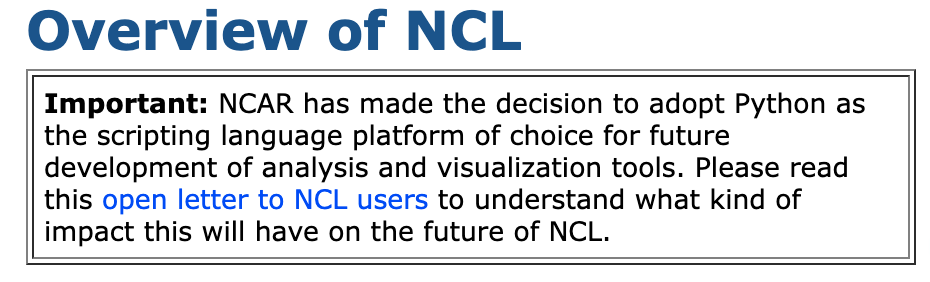

**The NCAR Command Language (NCL), a product of the Computational & Information Systems Laboratory at the National Center for Atmospheric Research (NCAR) and sponsored by the National Science Foundation, is a free interpreted language designed specifically for scientific data processing and visualization.**

### Install

- https://www.ncl.ucar.edu/Download/conda.shtml
- conda create -n ncl_stable -c conda-forge ncl

### Some functions

- load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_code.ncl"
  
- load "$NCARG_ROOT/lib/ncarg/nclscripts/wrf/WRFUserARW.ncl"
  
- a = addfile("/Users/mzapata/Desktop/workshop/2010083112/wrfout_d01_2010-08-31_18:00:00","r")

- slp = wrf_user_getvar(a,"slp",-1)

- tc2 = wrf_user_getvar(a,"T2",-1)   ; T2 in Kelvin

- u10 = wrf_user_getvar(a,"U10",-1)  ; u at 10 m

- v10 = wrf_user_getvar(a,"V10",-1)  ; v at 10 m

- ua  = wrf_user_getvar(a,"ua",-1)   ; u on mass points

- va  = wrf_user_getvar(a,"va",-1)   ; v on mass points

- avo = wrf_user_getvar(a,"avo",-1)    ; calculate avo for all times in file

- print (v10)

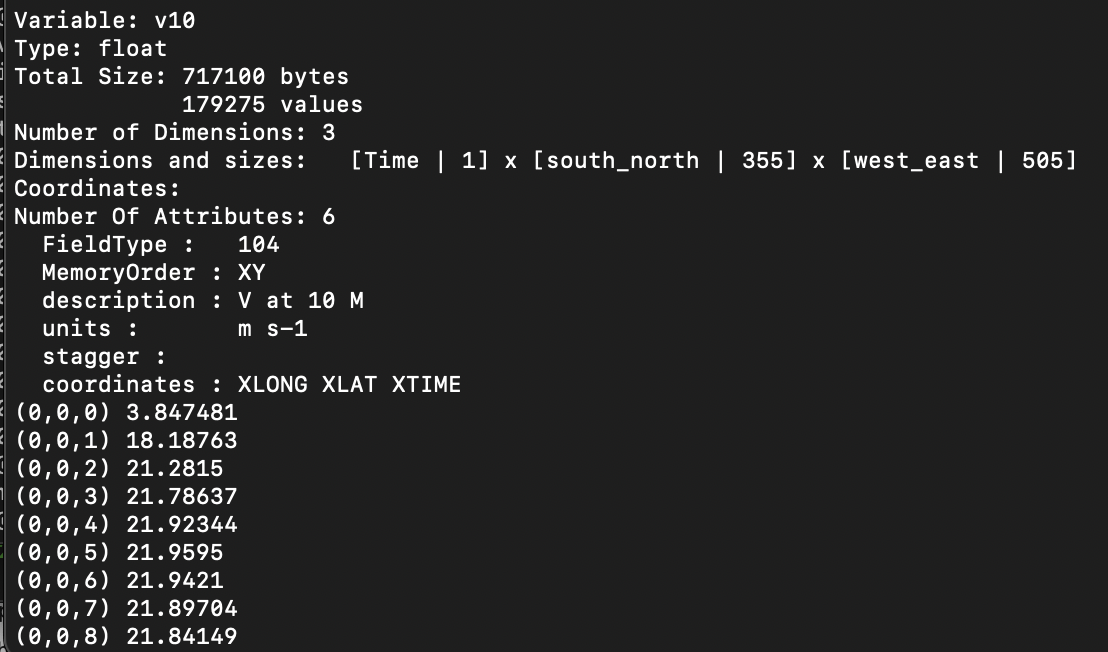

## PyWRF

- conda install conda-forge::wrf-python
- https://wrf-python.readthedocs.io/en/latest/

After conducting numerical integrations for the aforementioned TCs using both coupled and uncoupled versions of the **WRF** and CROCO models, we need to determine the simulated TC trajectories to compare our results with the trajectories in the **IBTrACS** dataset. To identify and distinguish TCs from other tropical disturbances in the atmospheric coupled and uncoupled model results, we applied a modified tracking methodology originally proposed by **Chauvin et al. (2006)**. This methodology relies on several key TC characteristics, including a warm core at higher altitudes resulting from latent heat release from
the sea surface, strong low-level winds, a minimum surface pressure at the storm’s center, and high vorticity at lower altitudes. The methodology comprises three steps: detection, separation, and selection. **In the first step, we identify pixels that meet the vorticity, temperature anomaly, and wind speed thresholds**. These threshold values, as taken from **Jullien et al. (2014)**, are listed below:

- Maximum 850 hPa wind speed > 17 $ms^{−1}$
- Mean 700 – 300 hPa temperature anomaly > $1^{\circ}K$
- Surface pressure is a local minimum
- 850 hPa vorticity > 20 $10^{−5}$ $s^{−1}$

In [11]:
from IPython.display import Image 
Image(url="Earl_track.png") 

In [50]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

In [44]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfhr_d01_2010-08-31_18:00:00')
)

### getvar

https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html

- **wrfin:** WRF-ARW NetCDF data as a netCDF4.Dataset
- **timeidx:** The desired time index
- **squeeze:** Set to False to prevent dimensions with a size of 1

- Leer con el nombre de la variable en los wrfout

In [23]:
lat = wrf.getvar(ncfile, "XLAT", timeidx=0, squeeze=True)
lon = wrf.getvar(ncfile, "XLONG",timeidx=0, squeeze=True)
lon = convert_longitude_to_0_360(lon)

In [22]:
lat.shape

(1, 355, 505)

- Leer con el nombre de la variable en PyWRF

In [24]:
lat = wrf.getvar(ncfile, "lat", timeidx=0, squeeze=True)
lon = wrf.getvar(ncfile, "lon", timeidx=0, squeeze=True)
lon = convert_longitude_to_0_360(lon)

In [48]:
wrf.getvar(ncfile, "U10", timeidx=[0,1,2,3,4], squeeze=False, meta=False).shape

(1, 5, 355, 505)

### destagger

In [49]:
from IPython.display import Image 
Image(url="stagger.png") 

https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.destagger.html

- **var:** A variable on a staggered grid.
- **timeidx:** The desired time index
- **stagger_dim:** The dimension index to destagger.
- **meta:** Set to False to disable metadata and return *numpy.ndarray* instead of *xarray.DataArray*

In [51]:
uu = wrf.getvar(ncfile, "U", timeidx=0)
print ('Stagger dimenssions', uu.shape)
us = wrf.destagger(uu, 2, meta=False)
print ('Unstagger dimenssions', us.shape)

Stagger dimenssions (40, 355, 506)
Unstagger dimenssions (40, 355, 505)


In [52]:
vv = wrf.getvar(ncfile, "V",timeidx=0)
print ('Stagger dimenssions', vv.shape)
vs = wrf.destagger(vv,1,meta=False)
print ('Unstagger dimenssions', us.shape)

Stagger dimenssions (40, 356, 505)
Unstagger dimenssions (40, 355, 505)


### Interpolation pressure level

In [53]:
from IPython.display import Image 
Image(url="interplev.png") 

https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.interplevel.html

- **field3d:** A three-dimensional field to interpolate
- **vert:** A three-dimensional array for the vertical coordinate, typically pressure or height
- **desiredlev:** he desired vertical level(s). This can be a single value (500), a sequence of values ([1000, 500, 250])

- Interpolar un nivel 

In [55]:
wrf.getvar(ncfile, "pressure").shape

(40, 355, 505)

In [56]:
pp = wrf.getvar(ncfile, "pressure")
uu_plev = wrf.interplevel(us, pp, 850.)
print ('Pressure interpolation dimensions', uu_plev.shape)

Pressure interpolation dimensions (355, 505)


- Interpolar un nivel 

In [58]:
pp = wrf.getvar(ncfile, "pressure")
uu_plev = wrf.interplevel(us, pp, [1000., 850., 500.])
print ('Pressure interpolation dimensions', uu_plev.shape)

Pressure interpolation dimensions (3, 355, 505)


### Wind speed 850 hPa > 17 $ms^{-1}$

In [59]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

# Three dimensional vertical coordinate
pp = wrf.getvar(ncfile, "pressure")

# Three dimensional field to interpolate
uu = wrf.getvar(ncfile, "U", timeidx=0)
vv = wrf.getvar(ncfile, "V", timeidx=0)

# Unstagger U and V three dimensional field
us = wrf.destagger(uu,2,meta=False)
vs = wrf.destagger(vv,1,meta=False)

# Interpolate U and V at 850 hPa 
uu_plev = wrf.interplevel(us, pp, 850.)
vv_plev = wrf.interplevel(vs, pp, 850.)

# Calculate wind speed 
ws_850 = magnitud(uu_plev,vv_plev)

print ('UU shape = ', uu_plev.shape)
print ('VV shape = ', uu_plev.shape)
print ('WS shape = ', uu_plev.shape)

UU shape =  (355, 505)
VV shape =  (355, 505)
WS shape =  (355, 505)


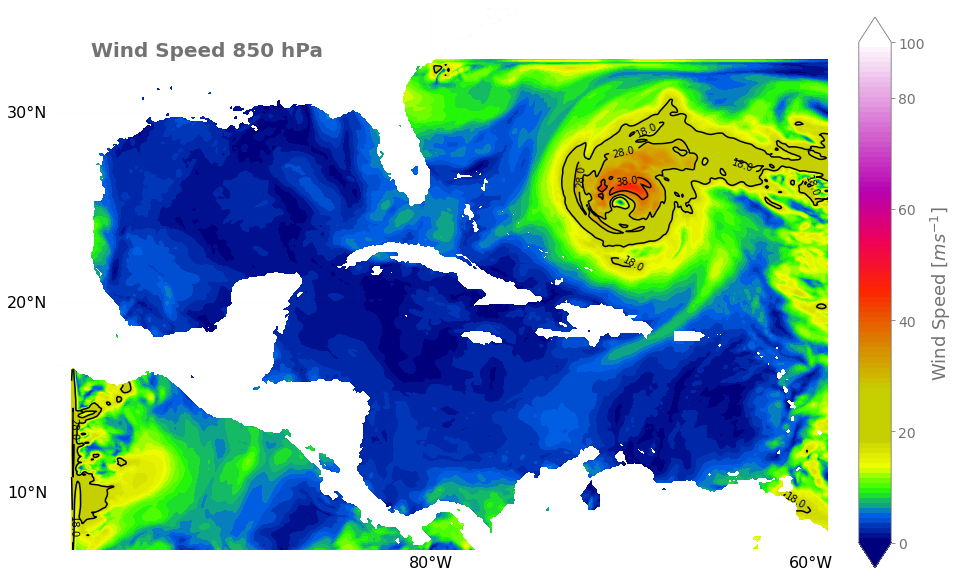

In [60]:
mask_wrf = mask_nan(
    file_name=path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)
graf_wrfout(ws_850,'WS',lon,lat,mask_wrf,f'Wind Speed 850 hPa','ws_example.png')

### Mean 700 – 300 hPa temperature anomaly > $1^{\circ}K$

In [61]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

# Three dimensional vertical coordinate
pp = wrf.getvar(ncfile, "pressure")

# Three dimensional field to interpolate
tt = wrf.getvar(ncfile,"tk") # ----> tk = Temperature in Kelvin

# Interpolate TT at 300 hPa 
tt_plev_300 = wrf.interplevel(tt,pp,300.)

# Calculate Anomalies 
tt_300_anom = tt_plev_300-np.nanmean(tt_plev_300)

In [63]:
tt_plev_300.shape

(355, 505)

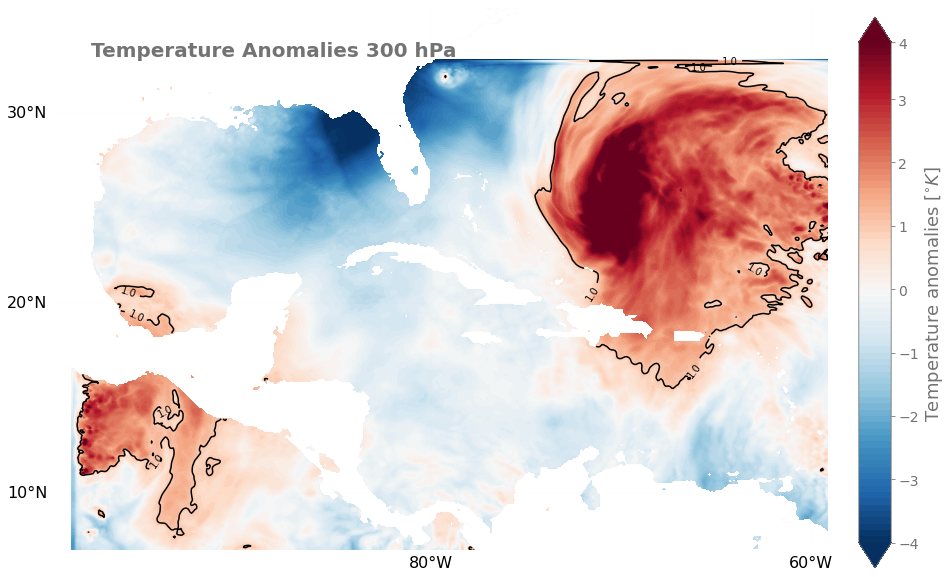

In [64]:
mask_wrf = mask_nan(
    file_name=path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)    

graf_wrfout(tt_300_anom,'TA',lon,lat,mask_wrf,f'Temperature Anomalies 300 hPa','ta_300_example.png')

In [65]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

# Three dimensional vertical coordinate
pp = wrf.getvar(ncfile, "pressure")

# Three dimensional field to interpolate
tt = wrf.getvar(ncfile,"tk") # ----> tk = Temperature in Kelvin

# Interpolate TT at 700 hPa 
tt_plev_700 = wrf.interplevel(tt, pp, 700.)

# Calculate Anomalies 
tt_700_anom = tt_plev_700-np.nanmean(tt_plev_700)

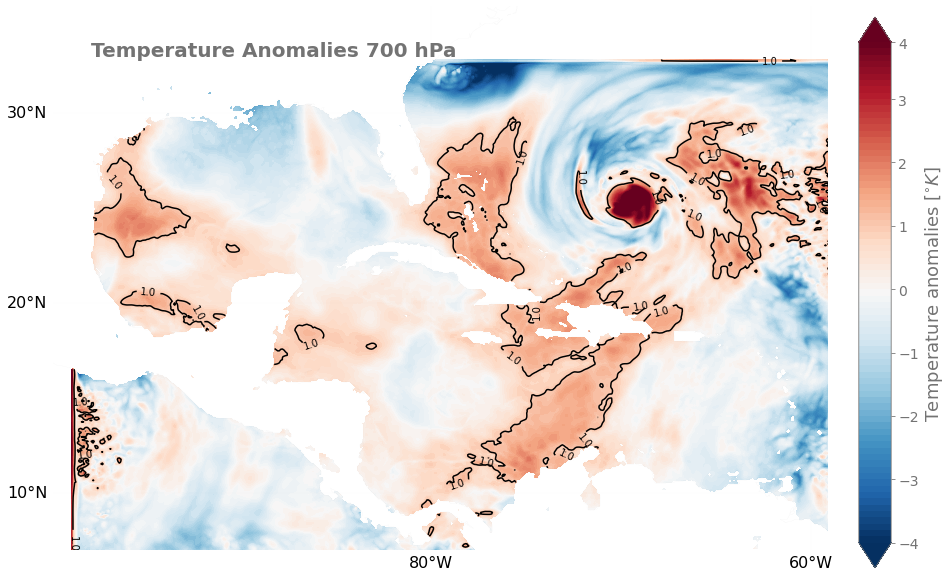

In [66]:
mask_wrf = mask_nan(
    file_name=path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)    

graf_wrfout(tt_700_anom,'TA',lon,lat,mask_wrf,f'Temperature Anomalies 700 hPa','ta_700_example.png')

### Vorticidad absoluta

Return the absolute vorticity. This function returns absolute vorticity [10-5 s-1], which is the sum of the relative vorticity at each grid point and the Coriolis parameter at the latitude


https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.avo.html

- **ustag:** The u component of the wind in [m s-1] that is at least three dimensions with a **staggered** west_east dimension.
- **vstag:** The v component of the wind in [m s-1] that is at least three dimensions with a **staggered** south_north dimension.
- **msfu:** The map scale factor on the u-grid
- **msfv:** The map scale factor on the v-grid
- **msfv:** The map scale factor on the v-grid
- **msfm:** The map scale factor on the mass grid
- **cor:** The Coriolis sine latitude
- **dx:** The distance between x grid points.
- **dy:** The distance between y grid points.

### Vorticity 850 hPa > 20 $10^{−5}$ $s^{−1}$

In [71]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

# Get two dimession variables
mapm = wrf.getvar(ncfile,'MAPFAC_M')
mapu = wrf.getvar(ncfile,'MAPFAC_U')
mapv = wrf.getvar(ncfile,'MAPFAC_V')
cori = wrf.getvar(ncfile,'F')*np.zeros_like(mapm)

# Get float attributes
dx = ncfile.DX
dy = ncfile.DY

# Three dimensional vertical coordinate
pp = wrf.getvar(ncfile, "pressure")

# Three dimensional staggered U and V 
uu = wrf.getvar(ncfile, "U", timeidx=0)
vv = wrf.getvar(ncfile, "V", timeidx=0)

# Calculate Absolute vorticity ---> Relative cori*0
vort = wrf.avo(ustag=uu,vstag=vv,msfu=mapu,msfv=mapv,msfm=mapm,cor=cori,dx=dx,dy=dy,meta=True)

# Interpolate Vort at 850 hPa 
vort_plev = wrf.interplevel(vort, pp, 850.)

In [72]:
vort_plev.shape

(355, 505)

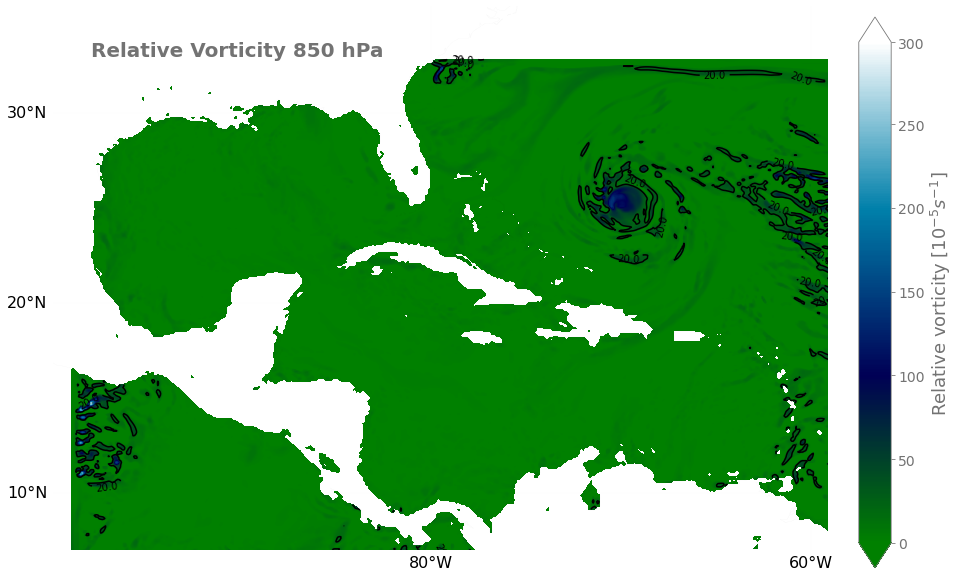

In [73]:
mask_wrf = mask_nan(
    file_name=path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)   

graf_wrfout(vort_plev,'VORT',lon,lat,mask_wrf,f'Relative Vorticity 850 hPa','vort_850_example.png')

### Find Vortex

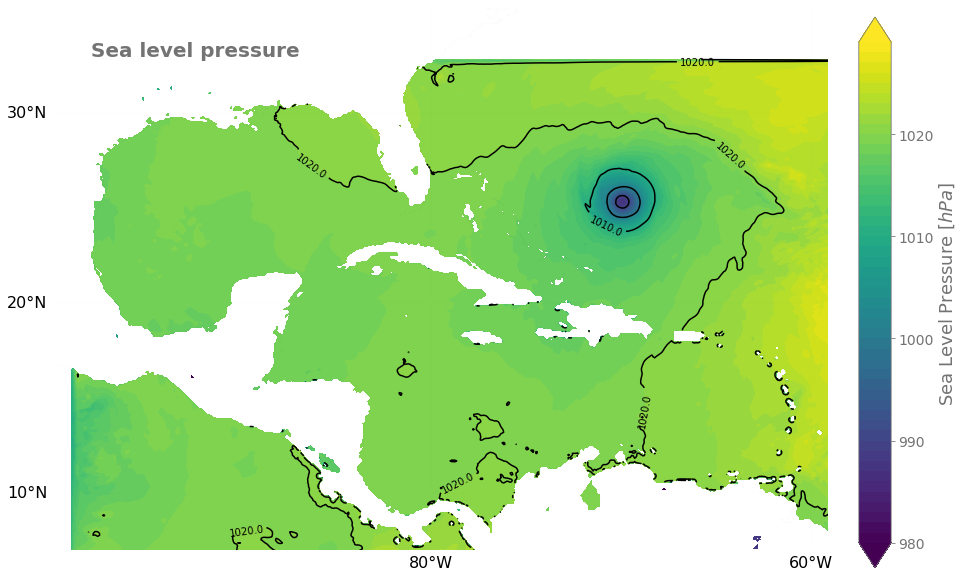

In [74]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)
slp = (wrf.getvar(ncfile, "PSFC"))/100.

graf_wrfout(slp,'PSFC',lon,lat,mask_wrf,f'Sea level pressure','psfc_example.png')

In [75]:
pos_vortex = np.where(
    (tt_700_anom.values > 1.) & 
    (tt_300_anom.values > 1.) &
    (vort_plev.values > 20.)  & 
    (ws_850.values > 17.)
)

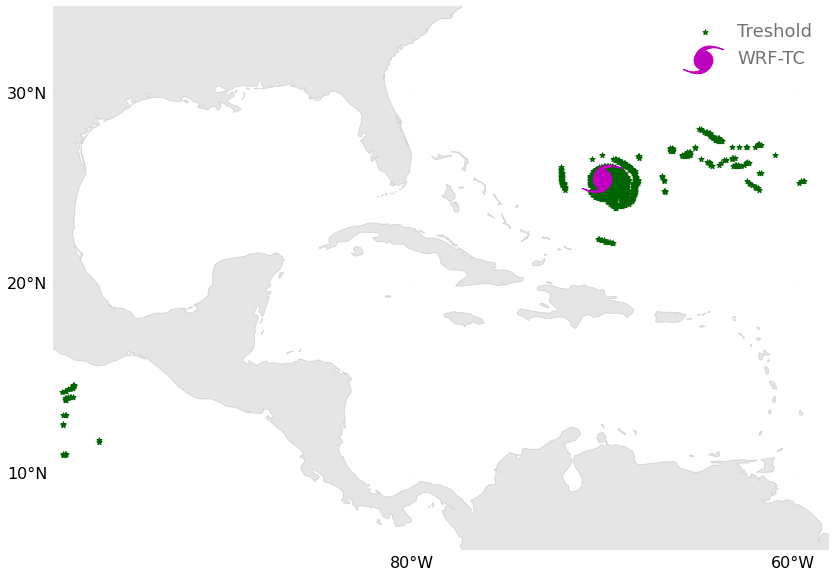

In [76]:
lon_vortex = lon.values[pos_vortex]
lat_vortex = lat.values[pos_vortex]
slp_vortex = slp.values[pos_vortex]

pos_min_slp = np.where(slp_vortex == np.min(slp_vortex))

graf_tcloc(lon_vortex, lat_vortex, pos_min_slp)

## Rainfall

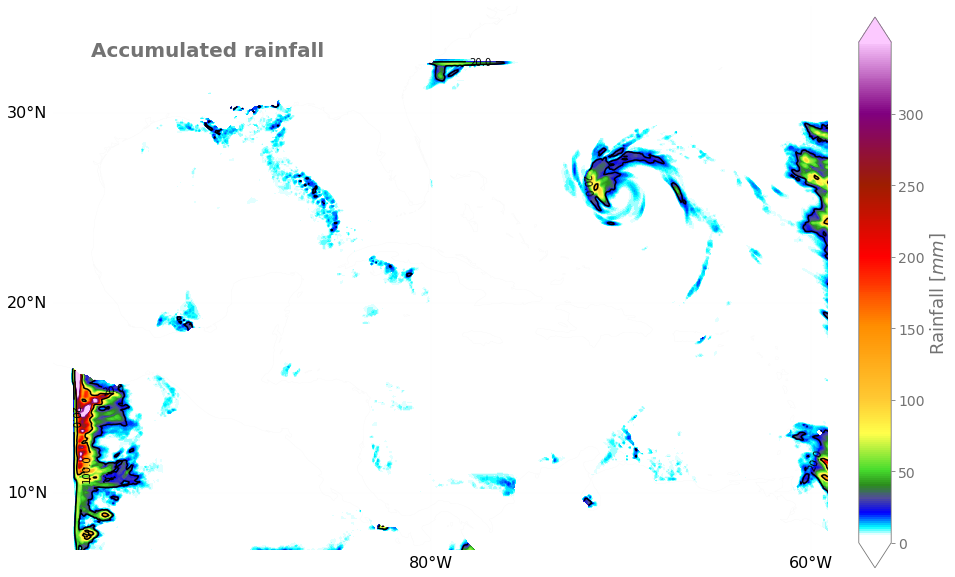

In [77]:
ncfile00 = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

ncfile11 = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_18:00:00')
)


rain = ((wrf.getvar(ncfile11,"RAINSH",timeidx=-1)+
         wrf.getvar(ncfile11,"RAINC",timeidx=-1)+
         wrf.getvar(ncfile11,"RAINNC",timeidx=-1)
        )-
        (wrf.getvar(ncfile00,"RAINSH",timeidx=-1)+
         wrf.getvar(ncfile00,"RAINC",timeidx=-1)+
         wrf.getvar(ncfile00,"RAINNC",timeidx=-1))
       )

graf_wrfout(rain,'PPT',lon,lat,mask_wrf,f'Accumulated rainfall','ppt_example.png')

## NETCDF4

In [82]:
ncfile = netCDF4.Dataset(
    path_data.joinpath('wrfout_d01_2010-09-01_12:00:00')
)

In [83]:
t2 = ncfile.variables['T2']

In [87]:
t2 = ncfile.variables['T2']
np.squeeze(t2, axis=0).shape

(355, 505)

In [88]:
uu = ncfile.variables['U']
uu.shape

(1, 40, 355, 506)

### https://xarray.dev/blog/introducing-xwrf 

## Xarray

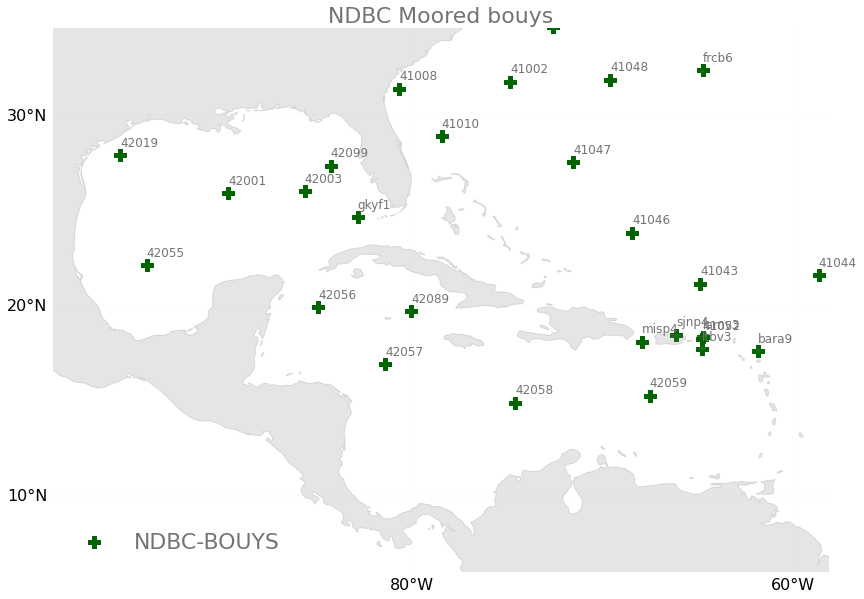

In [89]:
df_bouys = pd.read_csv('bouysAN_index.csv',index_col=0)
graf_bouysloc(df_bouys=df_bouys)

In [90]:
wrf_path_list = sorted(list(path_data.rglob(f'wrfout*')))
df_info_wrf = {idd: [ii] for idd, ii in enumerate(wrf_path_list)}
df_info_wrf = pd.DataFrame.from_dict(df_info_wrf, orient='index', columns=['path'])
df_info_wrf

path
0   /Users/mzapata/Desktop/workshop/2010083112/wrf...
1   /Users/mzapata/Desktop/workshop/2010083112/wrf...
2   /Users/mzapata/Desktop/workshop/2010083112/wrf...
3   /Users/mzapata/Desktop/workshop/2010083112/wrf...
4   /Users/mzapata/Desktop/workshop/2010083112/wrf...
5   /Users/mzapata/Desktop/workshop/2010083112/wrf...
6   /Users/mzapata/Desktop/workshop/2010083112/wrf...
7   /Users/mzapata/Desktop/workshop/2010083112/wrf...
8   /Users/mzapata/Desktop/workshop/2010083112/wrf...
9   /Users/mzapata/Desktop/workshop/2010083112/wrf...
10  /Users/mzapata/Desktop/workshop/2010083112/wrf...
11  /Users/mzapata/Desktop/workshop/2010083112/wrf...
12  /Users/mzapata/Desktop/workshop/2010083112/wrf...

In [91]:
mds_wrf = xr.open_mfdataset(
    paths=df_info_wrf.path.to_list(),
    chunks = {'Time': -1, 'XLAT':'auto', 'XLONG':'auto'},
    combine='nested',
    concat_dim='Time'
)

mds_wrf

<xarray.Dataset>
Dimensions:                (Time: 13, south_north: 355, west_east: 505,
                            bottom_top: 40, bottom_top_stag: 41,
                            soil_layers_stag: 5, west_east_stag: 506,
                            south_north_stag: 356)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/147)
    Times                  (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 41), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 5), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 5), meta=np.ndarray>
    ...                     ...
    ISEEDARR_SPPT          (Time, bottom_top) int32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    ISEEDARR_SKEBS         (Time, bottom_top) int32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    LANDMASK               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    LAKEMASK               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    SST                    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
    SST_INPUT              (Time, south_north, west_east) float32 dask.array<chunksize=(1, 178, 253), meta=np.ndarray>
Attributes: (12/116)
    TITLE:                            OUTPUT FROM WRF V3.7.1 MODEL
    START_DATE:                      2010-08-31_12:00:00
    SIMULATION_START_DATE:           2010-08-31_12:00:00
    WEST-EAST_GRID_DIMENSION:        506
    SOUTH-NORTH_GRID_DIMENSION:      356
    BOTTOM-TOP_GRID_DIMENSION:       41
    ...                              ...
    NUM_LAND_CAT:                    21
    ISWATER:                         17
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14

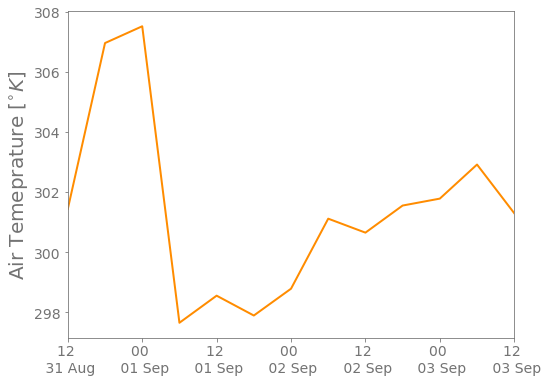

Bouy Coords LAT=21.575, LON=-58.625
WRFO Coords LAT=21.58917236328125, LON=-58.58589553833008


In [93]:
pos_sn, pos_we = get_nearest_index_from_xarray(
    ds_wrf=mds_wrf, 
    lat_point=df_bouys.latitud[4], 
    lon_point=df_bouys.longitud[4]
)

df_var = mds_wrf.T2.isel(
    {'south_north':pos_sn, 'west_east':pos_we}
).compute().to_dataframe().set_index('XTIME')

graf_time_series_xarray(
    df=df_var,
    var='T2',
    ylab='Air Temeprature $[^{\circ}K]$'
)

print (f'Bouy Coords LAT={df_bouys.latitud[4]}, LON={df_bouys.longitud[4]}')
print (f'WRFO Coords LAT={df_var.XLAT[0]}, LON={df_var.XLONG[0]}')

In [95]:
mds_wrf.sel('XLAT'=21.575, 'XLONG'=-58.62, method='nearest')

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-95-b75fa5b24b3d>, line 1)

In [96]:
df_var

XLAT      XLONG          T2
XTIME                                                
2010-08-31 12:00:00  21.589172 -58.585896  301.447205
2010-08-31 18:00:00  21.589172 -58.585896  306.965424
2010-09-01 00:00:00  21.589172 -58.585896  307.524017
2010-09-01 06:00:00  21.589172 -58.585896  297.655273
2010-09-01 12:00:00  21.589172 -58.585896  298.557312
2010-09-01 18:00:00  21.589172 -58.585896  297.896729
2010-09-02 00:00:00  21.589172 -58.585896  298.789551
2010-09-02 06:00:00  21.589172 -58.585896  301.119995
2010-09-02 12:00:00  21.589172 -58.585896  300.655090
2010-09-02 18:00:00  21.589172 -58.585896  301.557190
2010-09-03 00:00:00  21.589172 -58.585896  301.787659
2010-09-03 06:00:00  21.589172 -58.585896  302.921448
2010-09-03 12:00:00  21.589172 -58.585896  301.302338